import libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

read data into pd

In [2]:
data = pd.read_csv('email_with_predicted_roles_V2.csv')
data = data.drop(columns=['Content','Total_Sentence_Word_Count','From_Names','To_Names','Cleaned_Content','BoW','DateTime'])


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381581 entries, 0 to 381580
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   From       381581 non-null  object
 1   To         381581 non-null  object
 2   Subject    381581 non-null  object
 3   X-cc       381581 non-null  object
 4   X-bcc      381581 non-null  object
 5   Job_Title  381581 non-null  object
dtypes: object(6)
memory usage: 17.5+ MB


In [4]:
data.isnull().sum()

From         0
To           0
Subject      0
X-cc         0
X-bcc        0
Job_Title    0
dtype: int64

In [6]:
data["Job_Title"].nunique()

37

preprocess the data to remove weird and non-enron emails
- initially there are about 19k unique entries under From column

In [7]:
data['From'] = data['From'].str.strip().replace('', pd.NA)
data = data.dropna(subset=['From'])

# Filter rows where 'From' ends with '@enron.com' and does not contain numbers before '@enron.com'
filtered_data = data[
    data['From'].str.contains('@enron\.com$', na=False, regex=True) &  # Ends with '@enron.com'
    ~data['From'].str.contains(r'\d+@enron\.com$', na=False, regex=True)  # Does not contain numbers before '@enron.com'
]

<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Yap Yee Peng\AppData\Local\Temp\ipykernel_19560\710275862.py:6: SyntaxWarning: invalid escape sequence '\.'
  data['From'].str.contains('@enron\.com$', na=False, regex=True) &  # Ends with '@enron.com'


In [8]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381581 entries, 0 to 381580
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   From       381581 non-null  object
 1   To         381581 non-null  object
 2   Subject    381581 non-null  object
 3   X-cc       381581 non-null  object
 4   X-bcc      381581 non-null  object
 5   Job_Title  381581 non-null  object
dtypes: object(6)
memory usage: 17.5+ MB


In [14]:
filtered_data

,From,To,Subject,X-cc,X-bcc,Job_Title
0,richard.shapiro@enron.com,leslie.lawner@enron.com,Re: Talking points about California Gas market,"Christi L Nicolay, Joe Hartsoe, Rebecca W Cant...",X-Folder: \Phillip_Allen_Dec2000\Notes Folders...,"Vice President, Regulatory Affairs"
1,keith.holst@enron.com,k..allen@enron.com,FW: must see,X-bcc:,"X-Folder: \PALLEN (Non-Privileged)\Allen, Phil...",Director
2,john.lavorato@enron.com,k..allen@enron.com,RE: Chase Backtest,X-bcc:,"X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phil...","CEO, Enron America"
3,louise.kitchen@enron.com,"wes.colwell@enron.com, georgeanne.hodges@enron...",NETCO,"Lavorato, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phil...","President, Enron Online"
4,louise.kitchen@enron.com,"tim.belden@enron.com, f..calger@enron.com, m.....",Re-start/Integration Planning,"Lavorato, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phil...","President, Enron Online"
...,...,...,...,...,...,...
381576,john.zufferli@enron.com,kori.loibl@enron.com,Trade with John Lavorato,X-bcc:,"X-Folder: \ExMerge - Zufferli, John\Sent Items",Vice President
381577,john.zufferli@enron.com,john.lavorato@enron.com,Gas Hedges,X-bcc:,"X-Folder: \ExMerge - Zufferli, John\Sent Items",Vice President
381578,john.zufferli@enron.com,dawn.doucet@enron.com,RE: CONFIDENTIAL,X-bcc:,"X-Folder: \ExMerge - Zufferli, John\Sent Items","CEO, Enron America"
381579,john.zufferli@enron.com,jeanie.slone@enron.com,Calgary Analyst/Associate,X-bcc:,"X-Folder: \ExMerge - Zufferli, John\Sent Items",Analyst Risk Management


In [9]:
# Split the 'To' column into a list of recipients
filtered_data['To'] = filtered_data['To'].str.split(',')

filtered_data = filtered_data.explode('To')

filtered_data = filtered_data.dropna(subset=['From', 'To'])

filtered_data['From'] = filtered_data['From'].str.strip()
filtered_data['To'] = filtered_data['To'].str.strip()

filtered_data = filtered_data[filtered_data['From'].str.contains('@', na=False)]
filtered_data = filtered_data[filtered_data['To'].str.contains('@', na=False)]

filtered_data['To'] = filtered_data['To'].str.strip().replace('', pd.NA)
filtered_data = filtered_data.dropna(subset=['To'])

filtered_data_2 = filtered_data[
    filtered_data['To'].str.contains('@enron\.com$', na=False, regex=True) &
    ~filtered_data['To'].str.contains(r'\d+@enron\.com$', na=False, regex=True)
]


filtered_data_2.info()

<>:18: SyntaxWarning: invalid escape sequence '\.'
<>:18: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Yap Yee Peng\AppData\Local\Temp\ipykernel_19560\3051118151.py:18: SyntaxWarning: invalid escape sequence '\.'
  filtered_data['To'].str.contains('@enron\.com$', na=False, regex=True) &


<class 'pandas.core.frame.DataFrame'>
Index: 489586 entries, 0 to 381579
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   From       489586 non-null  object
 1   To         489586 non-null  object
 2   Subject    489586 non-null  object
 3   X-cc       489586 non-null  object
 4   X-bcc      489586 non-null  object
 5   Job_Title  489586 non-null  object
dtypes: object(6)
memory usage: 26.1+ MB


prepare node edges + create foundation for graph
- using From and To columns only, that will match with Job_Title later on

In [10]:
edges = filtered_data_2[['From', 'To']]

In [11]:
# Create a directed graph
G = nx.DiGraph()

# Add edges from the DataFrame
for _, row in edges.iterrows():
    G.add_edge(row['From'], row['To'])

1. Calculate degree centrality
- node's importance by counting the number of direct connetions (edges) it has to other nodes

In [12]:
degree_centrality = nx.degree_centrality(G)

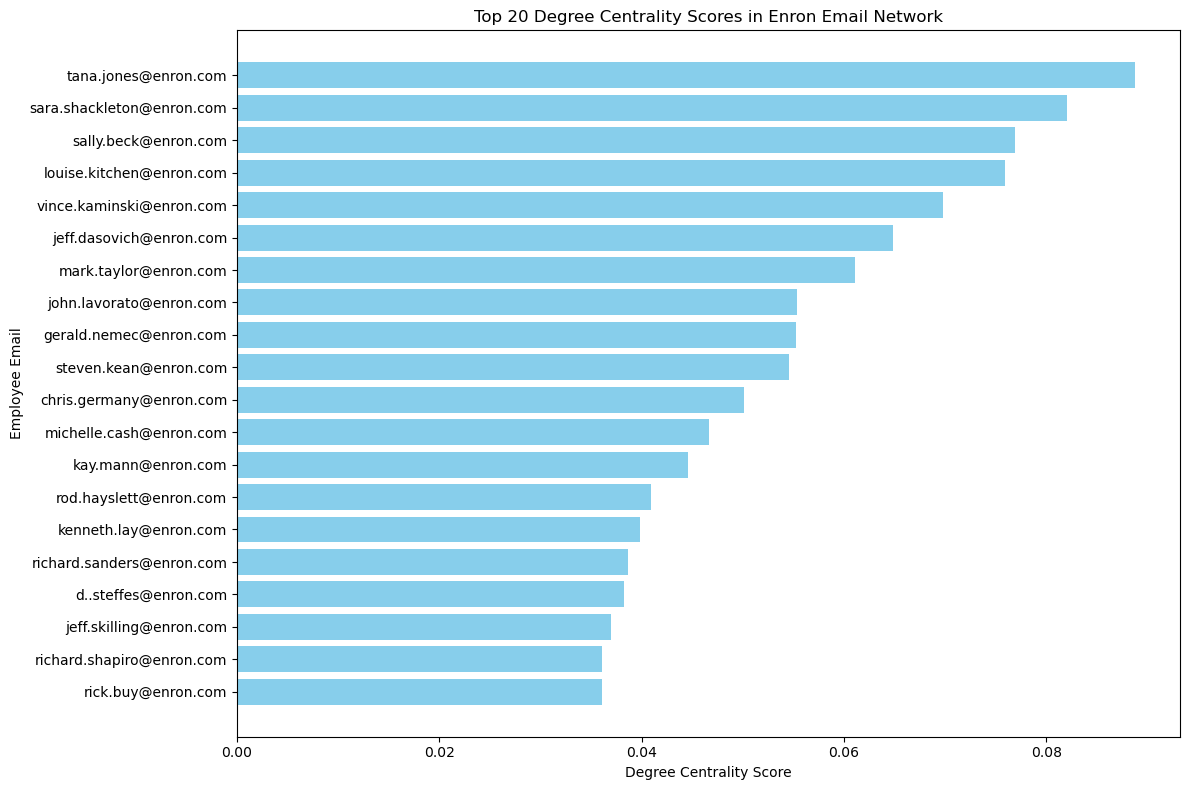

In [13]:
# Sort nodes by degree centrality scores in descending order
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 nodes with the highest degree centrality
top_20 = sorted_degree_centrality[:20]

# Extract names and scores for the bar graph
names = [x[0] for x in top_20]
scores = [x[1] for x in top_20]

plt.figure(figsize=(12, 8))
plt.barh(names, scores, color='skyblue')
plt.xlabel('Degree Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 20 Degree Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

In [14]:
# Extract email addresses of the top 20
top_20_emails = [x[0] for x in top_20]

# Create a dictionary to store email-job_title pairs
email_to_job_title = {}

# Look through the entire 'From' list and match with the top 20 emails
for email in top_20_emails:
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        email_to_job_title[email] = job_title[0]
    else:
        email_to_job_title[email] = 'Unknown'

top_20_with_titles = pd.DataFrame(top_20, columns=['email', 'degree_centrality'])
top_20_with_titles['Job_Title'] = top_20_with_titles['email'].map(email_to_job_title)

top_20_with_titles.head(20)

,email,degree_centrality,Job_Title
0,tana.jones@enron.com,0.088765,Vice President
1,sara.shackleton@enron.com,0.081998,Vice President
2,sally.beck@enron.com,0.076923,Chief Operating Officer
3,louise.kitchen@enron.com,0.075928,"President, Enron Online"
4,vince.kaminski@enron.com,0.069758,"Manager, Risk Management Head"
5,jeff.dasovich@enron.com,0.064882,Government Relation Executive
6,mark.taylor@enron.com,0.061101,"Managing Director, Legal Department"
7,john.lavorato@enron.com,0.055329,"CEO, Enron America"
8,gerald.nemec@enron.com,0.055229,Vice President
9,steven.kean@enron.com,0.054533,"Vice President, Vice President & Chief of Staff"


1.2 in-degree centrality
- <i>In-degree: No. of emails received
- <i>High in-degree - authority figures

In [15]:
in_degree_centrality = nx.in_degree_centrality(G)

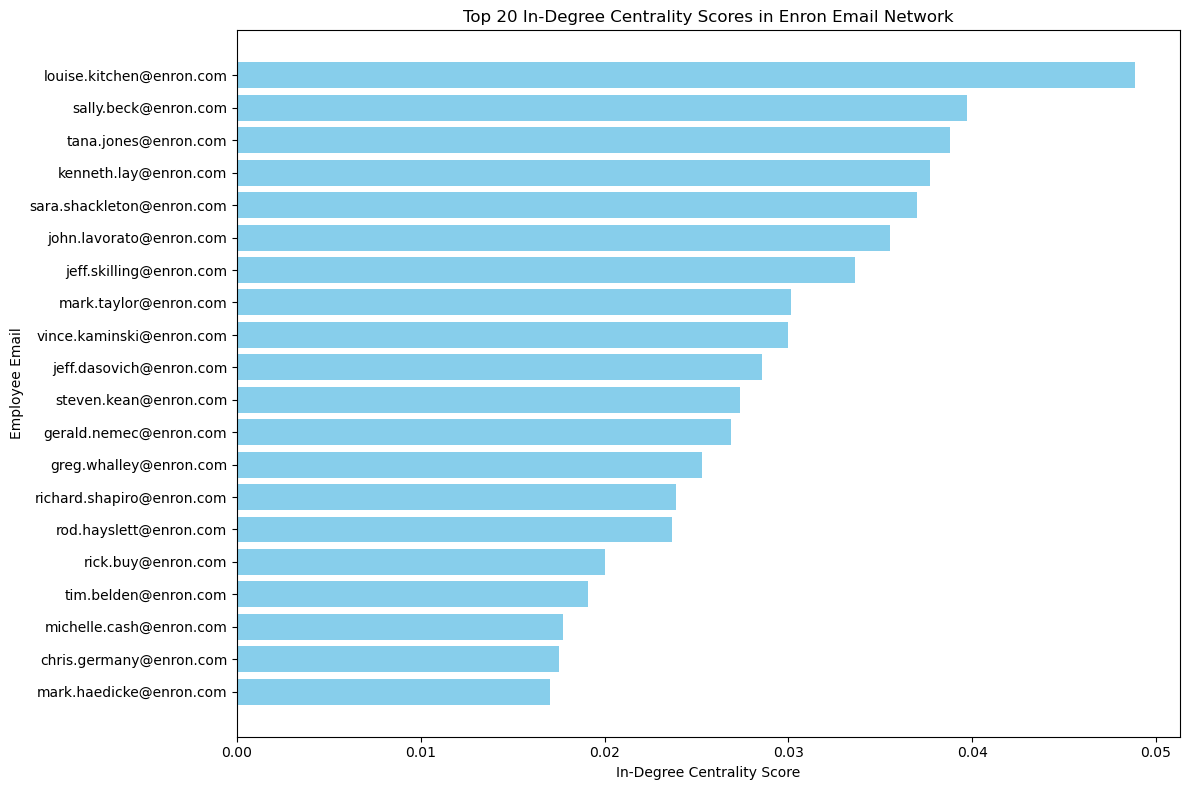

In [16]:
# Sort nodes by degree centrality scores in descending order
sorted_in_degree_centrality = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 nodes with the highest degree centrality
in_degree_top_20 = sorted_in_degree_centrality[:20]

# Extract names and scores for the bar graph
in_names = [x[0] for x in in_degree_top_20]
in_scores = [x[1] for x in in_degree_top_20]

plt.figure(figsize=(12, 8))
plt.barh(in_names, in_scores, color='skyblue')
plt.xlabel('In-Degree Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 20 In-Degree Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

In [19]:
# Extract email addresses of the top 20
in_top_20_emails = [x[0] for x in in_degree_top_20]

# Create a dictionary to store email-job_title pairs
in_email_to_job_title = {}

# Look through the entire 'From' list and match with the top 20 emails
for email in in_top_20_emails:
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        in_email_to_job_title[email] = job_title[0]
    else:
        in_email_to_job_title[email] = 'Unknown'

in_top_20_with_titles = pd.DataFrame(in_degree_top_20, columns=['email', 'in_degree_centrality'])
in_top_20_with_titles['Job_Title'] = in_top_20_with_titles['email'].map(in_email_to_job_title)

in_top_20_with_titles.head(20)

,email,in_degree_centrality,Job_Title
0,louise.kitchen@enron.com,0.048861,"President, Enron Online"
1,sally.beck@enron.com,0.039705,Chief Operating Officer
2,tana.jones@enron.com,0.038810,Vice President
3,kenneth.lay@enron.com,0.037715,CEO
4,sara.shackleton@enron.com,0.037019,Vice President
5,john.lavorato@enron.com,0.035526,"CEO, Enron America"
6,jeff.skilling@enron.com,0.033635,Government Relation Executive
7,mark.taylor@enron.com,0.030152,"Managing Director, Legal Department"
8,vince.kaminski@enron.com,0.029953,"Manager, Risk Management Head"
9,jeff.dasovich@enron.com,0.028560,Government Relation Executive


Makes sense that these higher position people are listed higher in degree centrality

1.3 out-degree centrality
- <i>Out-degree: No. of emails sent<i>
- <i>High out-degree - information spreaders<i>

In [20]:
out_degree_centrality = nx.out_degree_centrality(G)

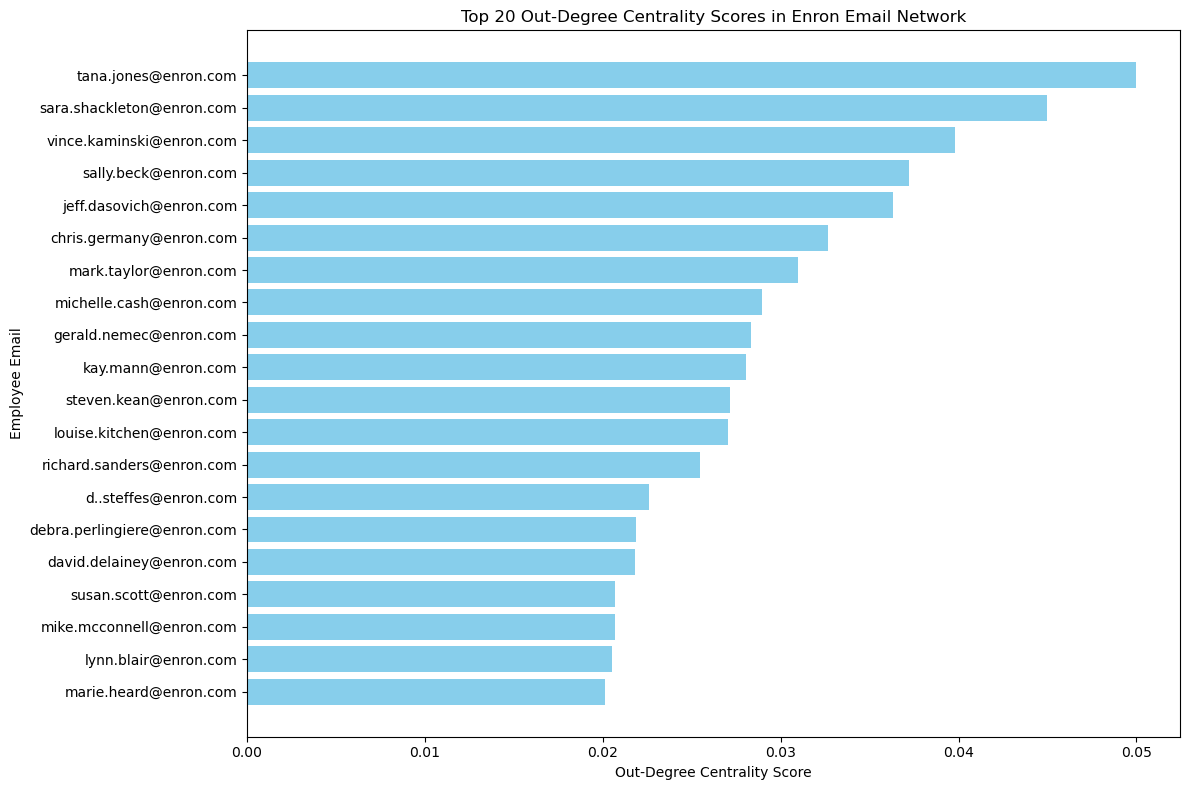

In [21]:
# Sort nodes by degree centrality scores in descending order
sorted_out_degree_centrality = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 nodes with the highest degree centrality
out_degree_top_20 = sorted_out_degree_centrality[:20]

# Extract names and scores for the bar graph
out_names = [x[0] for x in out_degree_top_20]
out_scores = [x[1] for x in out_degree_top_20]

plt.figure(figsize=(12, 8))
plt.barh(out_names, out_scores, color='skyblue')
plt.xlabel('Out-Degree Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 20 Out-Degree Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

In [22]:
# Extract email addresses of the top 20
out_top_20_emails = [x[0] for x in out_degree_top_20]

out_email_to_job_title = {}

for email in out_top_20_emails:
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        out_email_to_job_title[email] = job_title[0]
    else:
        out_email_to_job_title[email] = 'Unknown'

out_top_20_with_titles = pd.DataFrame(out_degree_top_20, columns=['email', 'out_degree_centrality'])
out_top_20_with_titles['Job_Title'] = out_top_20_with_titles['email'].map(out_email_to_job_title)

out_top_20_with_titles.head(20)

,email,out_degree_centrality,Job_Title
0,tana.jones@enron.com,0.049955,Vice President
1,sara.shackleton@enron.com,0.044980,Vice President
2,vince.kaminski@enron.com,0.039805,"Manager, Risk Management Head"
3,sally.beck@enron.com,0.037218,Chief Operating Officer
4,jeff.dasovich@enron.com,0.036322,Government Relation Executive
5,chris.germany@enron.com,0.032640,Vice President
6,mark.taylor@enron.com,0.030948,"Managing Director, Legal Department"
7,michelle.cash@enron.com,0.028958,Administrative Assistant
8,gerald.nemec@enron.com,0.028361,Vice President
9,kay.mann@enron.com,0.028062,Vice President


interesting that high position people are the ones sending out more emails ..
- extended to top 30 but still all high positions, would think that "normal" people are the ones that would rank higher in this

2. Calculate betweenness centrality
- <i>Betweenness centrality identifies individuals who act as bridges between different groups.<i>
- <i>Can be critical connectors in the network<i>
- <i>Highlighs bottlenecks and key intermediaries, may be essential for information flow and collaboration across departments<i>

In [23]:
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)  # Normalized by default

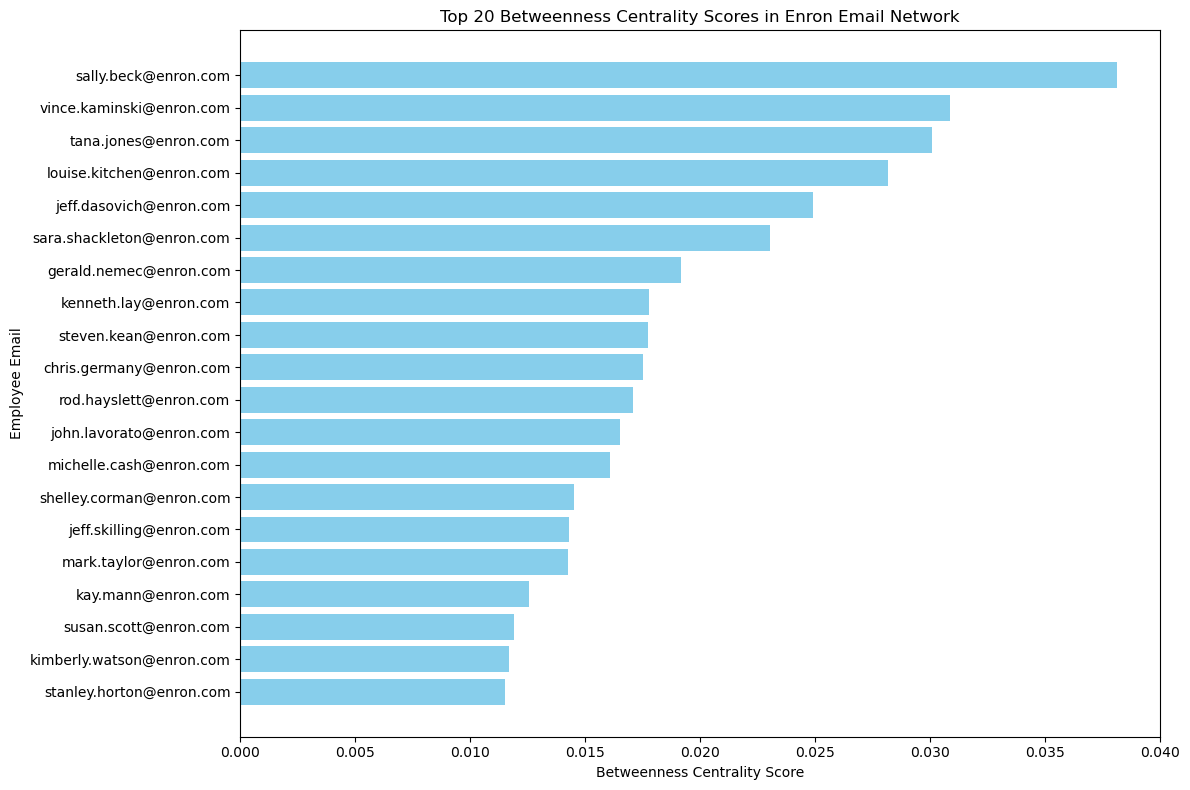

In [24]:
# Sort and print the top 20 individuals by betweenness centrality
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 nodes with the highest betweenness centrality
betweenness_top_20 = sorted_betweenness[:20]

# Extract names and scores for the bar graph
betweenness_names = [x[0] for x in betweenness_top_20]
betweenness_scores = [x[1] for x in betweenness_top_20]

plt.figure(figsize=(12, 8))
plt.barh(betweenness_names, betweenness_scores, color='skyblue')
plt.xlabel('Betweenness Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 20 Betweenness Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

In [25]:
# Extract email addresses of the top 20
betweenness_top_20_emails = [x[0] for x in betweenness_top_20]

betweenness_email_to_job_title = {}

for email in betweenness_top_20_emails:
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        betweenness_email_to_job_title[email] = job_title[0]
    else:
        betweenness_email_to_job_title[email] = 'Unknown'

betweenness_top_20_with_titles = pd.DataFrame(betweenness_top_20, columns=['email', 'between_centrality'])
betweenness_top_20_with_titles['Job_Title'] = betweenness_top_20_with_titles['email'].map(betweenness_email_to_job_title)

betweenness_top_20_with_titles.head(20)

,email,between_centrality,Job_Title
0,sally.beck@enron.com,0.038108,Chief Operating Officer
1,vince.kaminski@enron.com,0.030880,"Manager, Risk Management Head"
2,tana.jones@enron.com,0.030102,Vice President
3,louise.kitchen@enron.com,0.028178,"President, Enron Online"
4,jeff.dasovich@enron.com,0.024900,Government Relation Executive
5,sara.shackleton@enron.com,0.023037,Vice President
6,gerald.nemec@enron.com,0.019187,Vice President
7,kenneth.lay@enron.com,0.017795,CEO
8,steven.kean@enron.com,0.017721,"Vice President, Vice President & Chief of Staff"
9,chris.germany@enron.com,0.017523,Vice President


higher positions still seen over here
- no.2 - Manager, Risk Management Head | no.4 Government Relation Executive - seems to be more relevant in this case, since i would assume they would be involved more in the email chain

3. Calculate Closeness Centrality
- <i>Measures how close a node is to all other nodes in the network<i>
- <i>Closeness centrality measures how quickly an individual can communicate with others in the network.<i>
- <i>High closeness - individuals are centrally located in the network, can quickly reach out to others and disseminate information<i>
- <i>Identifies efficient communicators - ideal for broadcasting information or coordinating tasks | often central figures in the network<i>

In [26]:
closeness_centrality = nx.closeness_centrality(G)

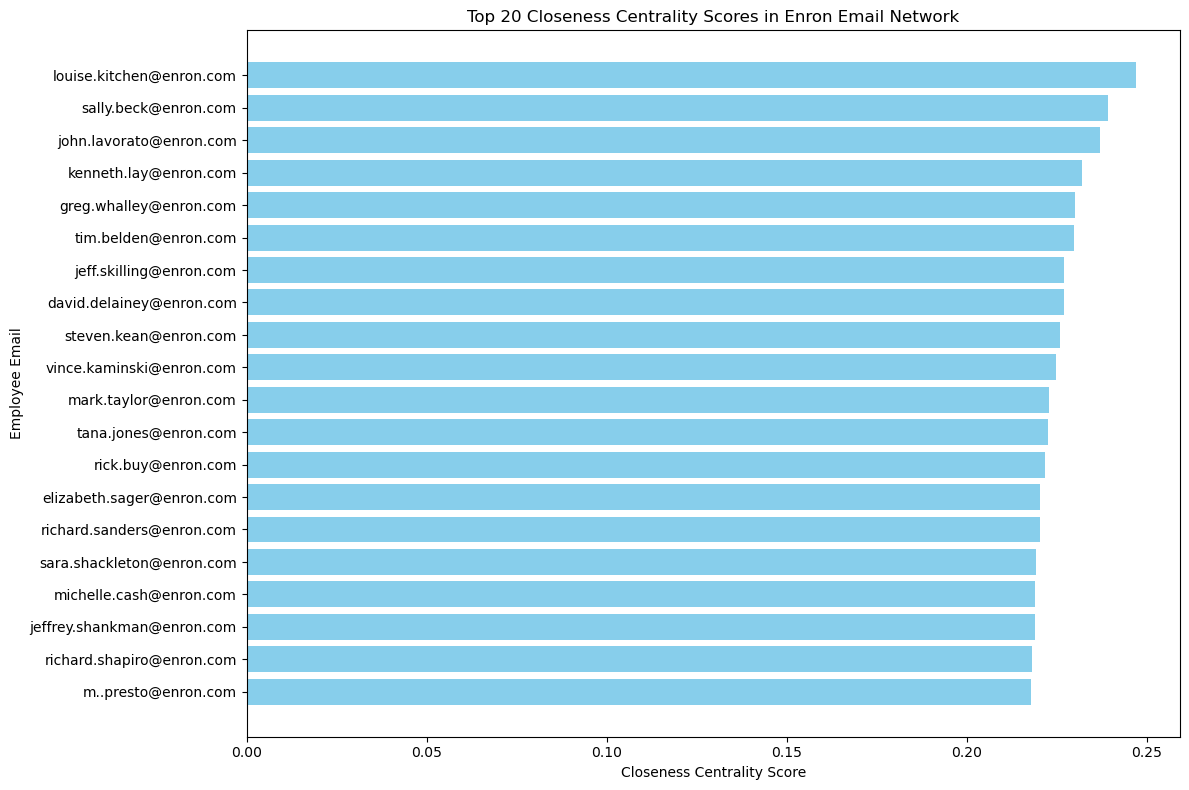

In [27]:
# Sort and print the top 20 individuals by betweenness centrality
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 nodes with the highest betweenness centrality
closeness_top_20 = sorted_closeness[:20]

# Extract names and scores for the bar graph
closeness_names = [x[0] for x in closeness_top_20]
closeness_scores = [x[1] for x in closeness_top_20]

plt.figure(figsize=(12, 8))
plt.barh(closeness_names, closeness_scores, color='skyblue')
plt.xlabel('Closeness Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 20 Closeness Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

In [28]:
# Extract email addresses of the top 20
closeness_top_20_emails = [x[0] for x in closeness_top_20]

closeness_email_to_job_title = {}

for email in closeness_top_20_emails:
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        closeness_email_to_job_title[email] = job_title[0]
    else:
        closeness_email_to_job_title[email] = 'Unknown'

closeness_top_20_with_titles = pd.DataFrame(closeness_top_20, columns=['email', 'closeness_centrality'])
closeness_top_20_with_titles['Job_Title'] = closeness_top_20_with_titles['email'].map(closeness_email_to_job_title)

closeness_top_20_with_titles.head(20)

,email,closeness_centrality,Job_Title
0,louise.kitchen@enron.com,0.246939,"President, Enron Online"
1,sally.beck@enron.com,0.239299,Chief Operating Officer
2,john.lavorato@enron.com,0.237157,"CEO, Enron America"
3,kenneth.lay@enron.com,0.232038,CEO
4,greg.whalley@enron.com,0.230194,Vice President
5,tim.belden@enron.com,0.229807,Vice President
6,jeff.skilling@enron.com,0.227195,Government Relation Executive
7,david.delainey@enron.com,0.227120,"CEO, Enron North America and Enron Energy Serv..."
8,steven.kean@enron.com,0.225964,"Vice President, Vice President & Chief of Staff"
9,vince.kaminski@enron.com,0.224923,"Manager, Risk Management Head"


Final Thoughts:
- in general, high position employees in Enron are seen - they are very much involved in email communications
- can choose to find out where the "normal" employees reside in the overall rankings

random chart of top 40 degree centrality - hard to interpret

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

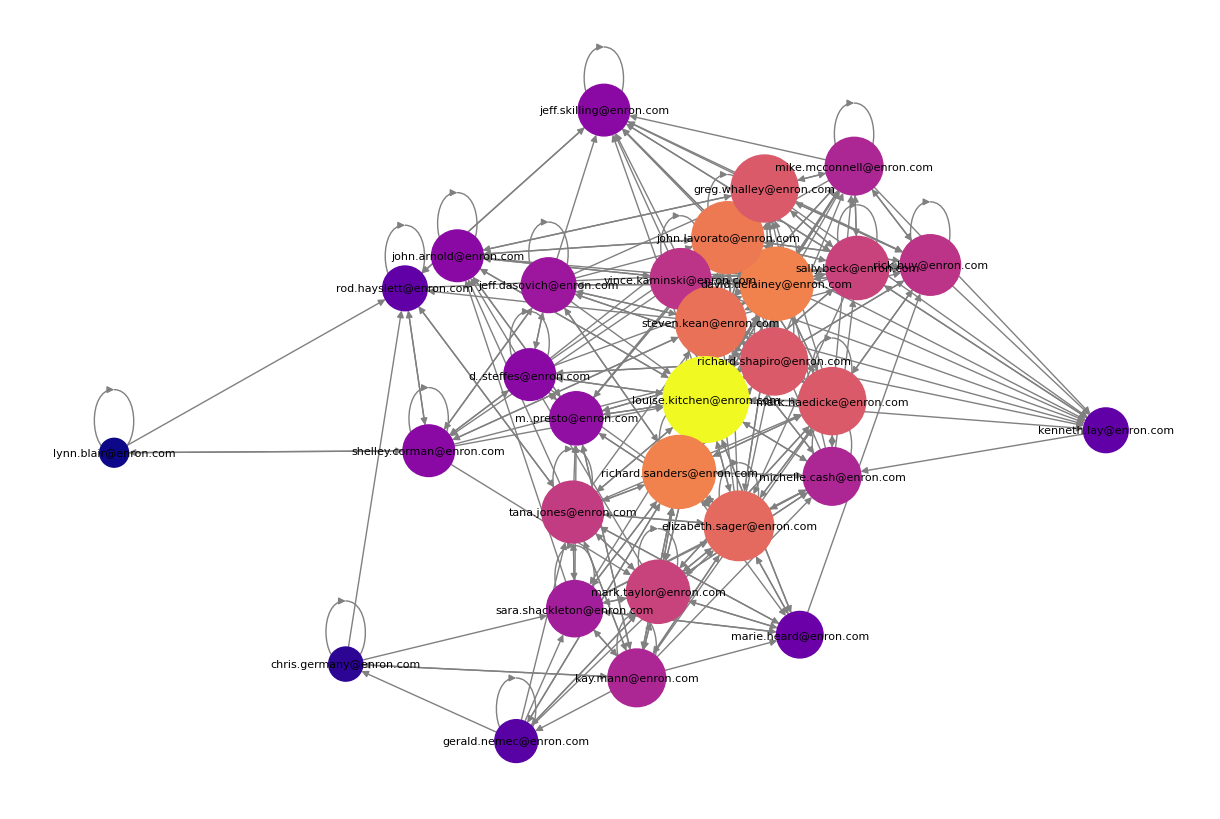

In [29]:
# Get the top 30 employees based on degree centrality
top_30 = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:30]

# Create a subgraph with the top 30 employees
subgraph = G.subgraph(top_30)

# Calculate degree centrality for the subgraph
subgraph_degree_centrality = nx.degree_centrality(subgraph)

# Set node size and color based on degree centrality
node_size = [v * 2500 for v in subgraph_degree_centrality.values()]  # Scale for visibility
node_color = [v * 50 for v in subgraph_degree_centrality.values()]  # Scale for color intensity

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.plasma, with_labels=True, font_size=8, font_color='black', edge_color='gray')

sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
sm.set_array([])
plt.colorbar(sm, label='Degree Centrality')

plt.title('Top 30 Employees by Degree Centrality')

In [31]:
def get_job_title_by_sender(data, sender):
    if "From" not in data.columns or "Job_Title" not in data.columns:
        return "Required columns not found in the dataset."

    # Filter rows where "From" matches the input
    matches = data[data["From"] == sender]

    if matches.empty:
        return f"No entry found for sender: {sender}"
    
    return matches["Job_Title"].tolist()

In [32]:
user_input = "richard.sanders@enron.com"
result = get_job_title_by_sender(data, user_input)

print("Job Title(s):", result)

Job Title(s): ['Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, Enron Wholesale Services', 'Vice President, 

In [33]:
print(data[data["From"] == "jeff.dasovich@enron.com"]["Job_Title"].unique())

['Government Relation Executive']


In [34]:
print(data[data["From"] == "chris.germany@enron.com"]["Job_Title"].unique())

['Vice President']


In [56]:
top_30

['tana.jones@enron.com',
 'sara.shackleton@enron.com',
 'sally.beck@enron.com',
 'louise.kitchen@enron.com',
 'vince.kaminski@enron.com',
 'jeff.dasovich@enron.com',
 'mark.taylor@enron.com',
 'john.lavorato@enron.com',
 'gerald.nemec@enron.com',
 'steven.kean@enron.com',
 'chris.germany@enron.com',
 'michelle.cash@enron.com',
 'kay.mann@enron.com',
 'rod.hayslett@enron.com',
 'kenneth.lay@enron.com',
 'richard.sanders@enron.com',
 'd..steffes@enron.com',
 'jeff.skilling@enron.com',
 'richard.shapiro@enron.com',
 'rick.buy@enron.com',
 'mike.mcconnell@enron.com',
 'mark.haedicke@enron.com',
 'elizabeth.sager@enron.com',
 'david.delainey@enron.com',
 'greg.whalley@enron.com',
 'marie.heard@enron.com',
 'lynn.blair@enron.com',
 'shelley.corman@enron.com',
 'm..presto@enron.com',
 'john.arnold@enron.com']

- jeff - found 2
- chris - found
- vince - NIL
- john - found 2
- mike - found

In [39]:
print("jeff.dasovich@enron.com: " + data[data["From"] == "jeff.dasovich@enron.com"]["Job_Title"].unique()) #'Government Relation Executive'
print("jeff.skilling@enron.com: " + data[data["From"] == "jeff.skilling@enron.com"]["Job_Title"].unique()) #'Government Relation Executive'
print("chris.germany@enron.com: " + data[data["From"] == "chris.germany@enron.com"]["Job_Title"].unique()) #'Vice President'
print("vince.kaminski@enron.com: " + data[data["From"] == "vince.kaminski@enron.com"]["Job_Title"].unique()) #'Vice President'
print("john.lavorato@enron.com: " + data[data["From"] == "john.lavorato@enron.com"]["Job_Title"].unique()) #'CEO, Enron America'
print("john.arnold@enron.com: " + data[data["From"] == "john.arnold@enron.com"]["Job_Title"].unique()) #'Vice President'
print("mike.mcconnell@enron.com: " + data[data["From"] == "mike.mcconnell@enron.com"]["Job_Title"].unique()) #'Vice President'


['jeff.dasovich@enron.com: Government Relation Executive']
['jeff.skilling@enron.com: Government Relation Executive']
['chris.germany@enron.com: Vice President']
['vince.kaminski@enron.com: Manager, Risk Management Head']
['john.lavorato@enron.com: CEO, Enron America']
['john.arnold@enron.com: Vice President']
['mike.mcconnell@enron.com: Vice President']
